In [26]:
import cv2
import numpy as np
import copy
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
from typing import List
from Crypto.Cipher import DES

# Initial Permutation
IP = [58, 50, 42, 34, 26, 18, 10, 2,
      60, 52, 44, 36, 28, 20, 12, 4,
      62, 54, 46, 38, 30, 22, 14, 6,
      64, 56, 48, 40, 32, 24, 16, 8,
      57, 49, 41, 33, 25, 17, 9, 1,
      59, 51, 43, 35, 27, 19, 11, 3,
      61, 53, 45, 37, 29, 21, 13, 5,
      63, 55, 47, 39, 31, 23, 15, 7]

# Final Permutation
FP = [40, 8, 48, 16, 56, 24, 64, 32,
        39, 7, 47, 15, 55, 23, 63, 31,
        38, 6, 46, 14, 54, 22, 62, 30,
        37, 5, 45, 13, 53, 21, 61, 29,
        36, 4, 44, 12, 52, 20, 60, 28,
        35, 3, 43, 11, 51, 19, 59, 27,
        34, 2, 42, 10, 50, 18, 58, 26,
        33, 1, 41, 9, 49, 17, 57, 25]

# Expansion P-box
EP = [32, 1, 2, 3, 4, 5,
     4, 5, 6, 7, 8, 9,
     8, 9, 10, 11, 12, 13,
     12, 13, 14, 15, 16, 17,
     16, 17, 18, 19, 20, 21,
     20, 21, 22, 23, 24, 25,
     24, 25, 26, 27, 28, 29,
     28, 29, 30, 31, 32, 1]

#SBOX
S_Box = [
         
[[14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7],
 [0, 15, 7, 4, 14, 2, 13, 1, 10, 6, 12, 11, 9, 5, 3, 8],
 [4, 1, 14, 8, 13, 6, 2, 11, 15, 12, 9, 7, 3, 10, 5, 0],
 [15, 12, 8, 2, 4, 9, 1, 7, 5, 11, 3, 14, 10, 0, 6, 13],
],

[[15, 1, 8, 14, 6, 11, 3, 4, 9, 7, 2, 13, 12, 0, 5, 10],
 [3, 13, 4, 7, 15, 2, 8, 14, 12, 0, 1, 10, 6, 9, 11, 5],
 [0, 14, 7, 11, 10, 4, 13, 1, 5, 8, 12, 6, 9, 3, 2, 15],
 [13, 8, 10, 1, 3, 15, 4, 2, 11, 6, 7, 12, 0, 5, 14, 9],
],

[[10, 0, 9, 14, 6, 3, 15, 5, 1, 13, 12, 7, 11, 4, 2, 8],
 [13, 7, 0, 9, 3, 4, 6, 10, 2, 8, 5, 14, 12, 11, 15, 1],
 [13, 6, 4, 9, 8, 15, 3, 0, 11, 1, 2, 12, 5, 10, 14, 7],
 [1, 10, 13, 0, 6, 9, 8, 7, 4, 15, 14, 3, 11, 5, 2, 12],
],

[[7, 13, 14, 3, 0, 6, 9, 10, 1, 2, 8, 5, 11, 12, 4, 15],
 [13, 8, 11, 5, 6, 15, 0, 3, 4, 7, 2, 12, 1, 10, 14, 9],
 [10, 6, 9, 0, 12, 11, 7, 13, 15, 1, 3, 14, 5, 2, 8, 4],
 [3, 15, 0, 6, 10, 1, 13, 8, 9, 4, 5, 11, 12, 7, 2, 14],
],  

[[2, 12, 4, 1, 7, 10, 11, 6, 8, 5, 3, 15, 13, 0, 14, 9],
 [14, 11, 2, 12, 4, 7, 13, 1, 5, 0, 15, 10, 3, 9, 8, 6],
 [4, 2, 1, 11, 10, 13, 7, 8, 15, 9, 12, 5, 6, 3, 0, 14],
 [11, 8, 12, 7, 1, 14, 2, 13, 6, 15, 0, 9, 10, 4, 5, 3],
], 

[[12, 1, 10, 15, 9, 2, 6, 8, 0, 13, 3, 4, 14, 7, 5, 11],
 [10, 15, 4, 2, 7, 12, 9, 5, 6, 1, 13, 14, 0, 11, 3, 8],
 [9, 14, 15, 5, 2, 8, 12, 3, 7, 0, 4, 10, 1, 13, 11, 6],
 [4, 3, 2, 12, 9, 5, 15, 10, 11, 14, 1, 7, 6, 0, 8, 13],
], 

[[4, 11, 2, 14, 15, 0, 8, 13, 3, 12, 9, 7, 5, 10, 6, 1],
 [13, 0, 11, 7, 4, 9, 1, 10, 14, 3, 5, 12, 2, 15, 8, 6],
 [1, 4, 11, 13, 12, 3, 7, 14, 10, 15, 6, 8, 0, 5, 9, 2],
 [6, 11, 13, 8, 1, 4, 10, 7, 9, 5, 0, 15, 14, 2, 3, 12],
],
   
[[13, 2, 8, 4, 6, 15, 11, 1, 10, 9, 3, 14, 5, 0, 12, 7],
 [1, 15, 13, 8, 10, 3, 7, 4, 12, 5, 6, 11, 0, 14, 9, 2],
 [7, 11, 4, 1, 9, 12, 14, 2, 0, 6, 10, 13, 15, 3, 5, 8],
 [2, 1, 14, 7, 4, 10, 8, 13, 15, 12, 9, 0, 3, 5, 6, 11],
]
]

# Straight P-box
SP = [16, 7, 20, 21, 29, 12, 28, 17,
     1, 15, 23, 26, 5, 18, 31, 10,
     2, 8, 24, 14, 32, 27, 3, 9,
     19, 13, 30, 6, 22, 11, 4, 25]

# Number of bit shifts
SHIFT = [1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,1]

# Parity drop table
PD_Table = [57, 49, 41, 33, 25, 17, 9,
        1, 58, 50, 42, 34, 26, 18,
        10, 2, 59, 51, 43, 35, 27,
        19, 11, 3, 60, 52, 44, 36,
        63, 55, 47, 39, 31, 23, 15,
        7, 62, 54, 46, 38, 30, 22,
        14, 6, 61, 53, 45, 37, 29,
        21, 13, 5, 28, 20, 12, 4]

# Compression P-box
CP_Box = [14, 17, 11, 24, 1, 5, 3, 28,
        15, 6, 21, 10, 23, 19, 12, 4,
        26, 8, 16, 7, 27, 20, 13, 2,
        41, 52, 31, 37, 47, 55, 30, 40,
        51, 45, 33, 48, 44, 49, 39, 56,
        34, 53, 46, 42, 50, 36, 29, 32]
     


# 전체 키 구하기
def KeyScheduling(masterkey):
    # masterkey는 64bit=8bytes
    # 1byte 씩 8개 원소 갖는 list로 받기
    masterkey_list = []
    for num in masterkey:
        tmp = bin(num)
        tmp = tmp[2:]
        tmp = list(tmp)
        if len(tmp) < 8:
            for _ in range(8-len(tmp)):
                tmp.insert(0,'0')
        
        for bit in tmp:
            masterkey_list.append(bit)
    
    CipherKey = []
    for idx in PD_Table:
        CipherKey.append(masterkey_list[idx-1])
    
    WholeKey = []
    Left = copy.deepcopy(CipherKey[:28])
    Right = copy.deepcopy(CipherKey[28:])
    
    for rnd in range(16):
        Left = Left[SHIFT[rnd]:]+Left[:SHIFT[rnd]]
        Right = Right[SHIFT[rnd]:]+Right[:SHIFT[rnd]]
        
        # R_key : 라운드별 키 (48bits)
        R_key = ''
        tmp = Left+Right
        for idx in CP_Box:
            R_key += tmp[idx-1]
        
        WholeKey.append(R_key)
    
    # 각 라운드 별 key 리턴 (48bit, list of string)
    return WholeKey

# Initial Permutation
def InitialPermutation(plaintext):
    # plaintext 64bit=8bytes=1block
    # 1byte 씩 8개 원소 갖는 list로 받기
    plain = ''
    for num in plaintext:
        tmp = bin(num)
        tmp = tmp[2:]
        tmp = list(tmp)
        if len(tmp) < 8:
            for _ in range(8-len(tmp)):
                tmp.insert(0,'0')
        
        for bit in tmp:
            plain += bit
    
    init_per = ''
    for idx in IP:
        init_per += plain[idx-1]
    
    # init_per : Initial Permutation 결과
    # 64bit, string
    return init_per

# Final Permutation
def FinalPermutation(ciphertext):
    # plaintext 64bit=8bytes=1block
    # 1byte 씩 8개 원소 갖는 list로 받기
    cipher = ''
    for num in ciphertext:
        tmp = bin(num)
        tmp = tmp[2:]
        tmp = list(tmp)
        if len(tmp) < 8:
            for _ in range(8-len(tmp)):
                tmp.insert(0,'0')
        
        for bit in tmp:
            cipher += bit
    
    final_per = ''
    for idx in FP:
        final_per += cipher[idx-1]
    
    # init_per : Initial Permutation 결과
    # 64bit, string
    return final_per

def RoundFunction(text, key):
    # text : 64bit string
    # key : 48bit string
    # Swapping 따로 (마지막 라운드는 swap X)
    Left = text[:32]
    Right = text[32:]
    
    expansion = ''
    for idx in EP:
        expansion += Right[idx-1]
    
    xor = ''
    for i in range(len(key)):
        bit1 = int(expansion[i])
        bit2 = int(key[i])
        bit = bit1 ^ bit2
        xor += str(bit)
    
    S_input = []
    for i in range(0, len(xor), 6):
        tmp = copy.deepcopy(xor[i:i+6])
        S_input.append(tmp)
    
    S_output = ''
    for idx in range(8):
        row = ''
        column = ''
        row += S_input[idx][0]
        row += S_input[idx][5]
        column += S_input[idx][1:5]
        row = int(row, 2)
        column = int(column, 2)
        
        entry = S_Box[idx][row][column]
        entry = bin(entry)
        entry = entry[2:]
        
        if len(entry) < 4:
            tmp = ''
            for i in range(4-len(entry)):
                tmp += '0'
            
            entry = tmp+entry
        
        S_output += entry
    
    f_output = ''
    for idx in SP:
        f_output += S_output[idx-1]
    
    mixer = ''
    for i in range(len(f_output)):
        bit1 = int(Left[i])
        bit2 = int(f_output[i])
        bit = bit1 ^ bit2
        mixer += str(bit)
    
    # mixer, Right : 32bit, string
    return mixer, Right

def Swapper(left, right):
    return right, left

def DES_encryption(plainblock, masterkey, round=16):
    # plainblock : 64bit
    # 1byte씩 8개 원소 list로 받기
    # masterkey : 64bit
    # 1byte씩 8개 원소 list로 받기
    wholekey = KeyScheduling(masterkey)
    block = copy.deepcopy(plainblock)
    block = InitialPermutation(block)
    
    left = ''
    right = ''
    for i in range(round-1):
        left, right = RoundFunction(block, wholekey[i])
        left, right = Swapper(left, right)
        block = left+right
    
    left, right = RoundFunction(block, wholekey[round-1])
    
    block = left+right
    cipherblock = []
    for i in range(0,len(block),8):
        tmp = block[i:i+8]
        cipherblock.append(int(tmp,2))
    
    final_per = FinalPermutation(cipherblock)
    
    cipherblock = []
    for i in range(0,len(final_per),8):
        cipherblock.append(int(final_per[i:i+8], 2))
    
    # cipherblock : 1byte씩 8개 원소 list
    return cipherblock

def DES_decryption(cipherblock, masterkey, round=16):
    # cipherblock : 64bit
    # 1byte씩 8개 원소 list로 받기
    # masterkey : 64bit
    # 1byte씩 8개 원소 list로 받기
    wholekey = KeyScheduling(masterkey)
    block = copy.deepcopy(cipherblock)
    block = InitialPermutation(block)
    
    left = ''
    right = ''
    for i in range(round-1, 0, -1):
        left, right = RoundFunction(block, wholekey[i])
        left, right = Swapper(left, right)
        block = left+right
    
    left, right = RoundFunction(block, wholekey[0])
    
    block = left+right
    plainblock = []
    for i in range(0,len(block),8):
        tmp = block[i:i+8]
        plainblock.append(int(tmp,2))
    
    final_per = FinalPermutation(plainblock)
    
    plainblock = []
    for i in range(0,len(final_per),8):
        plainblock.append(int(final_per[i:i+8], 2))
    
    # plainblock : 1byte씩 8개 원소 list
    return plainblock   

def DES_ECB(plain, masterkey, round=16):
  # plain : image to array, shape = (128,,128,3) 으로 받기
  # key : 64bits=8bytes, 1bytes 8개 list로 받기
  plain = plain.transpose(2,0,1)
  plain_list = plain.tolist()

  cipher_ecb = []

  ylen = len(plain_list[0])
  xlen = len(plain_list[0][0])
  channel = len(plain_list)
  for i in range(channel):
    cipher = []
    for j in range(ylen):
      cipherblocks = []
      for k in range(0,xlen,8):
        plainblock = copy.deepcopy(plain_list[i][j][k:k+8])
        cipherblocks += DES_encryption(plainblock, masterkey, round)
      cipher.append(copy.deepcopy(cipherblocks))
    cipher_ecb.append(copy.deepcopy(cipher))
  
  cipher_ecb = np.array(cipher_ecb)
  cipher_ecb = cipher_ecb.transpose(1,2,0)
  return cipher_ecb
     

def DES_CBC(plain, masterkey, IV = [0,0,0,0,0,0,0,0], round=16):
  # plain : image to array, shape = (128,,128,3) 으로 받기
  # key : 64bits=8bytes, 1bytes 8개 list로 받기
  plain = plain.transpose(2,0,1)
  plain_list = plain.tolist()
  iv = IV

  cipher_cbc = []

  ylen = len(plain_list[0])
  xlen = len(plain_list[0][0])
  channel = len(plain_list)
  for i in range(channel):
    cipher = []
    for j in range(ylen):
      cipherblocks = []
      for k in range(0,xlen,8):
        plainblock = copy.deepcopy(plain_list[i][j][k:k+8])
        for s in range(len(plainblock)):
          plainblock[s] ^= iv[s]
        cipherblock = DES_encryption(plainblock, masterkey, round)
        iv = copy.deepcopy(cipherblock)
        cipherblocks += cipherblock
      cipher.append(copy.deepcopy(cipherblocks))
    cipher_cbc.append(copy.deepcopy(cipher))
  
  cipher_cbc = np.array(cipher_cbc)
  cipher_cbc = cipher_cbc.transpose(1,2,0)
  return cipher_cbc
     

def DES_OFB(plain, masterkey, IV = [0,0,0,0,0,0,0,0], round=16):
  # plain : image to array, shape = (128,,128,3) 으로 받기
  # key : 64bits=8bytes, 1bytes 8개 list로 받기
  plain = plain.transpose(2,0,1)
  plain_list = plain.tolist()
  iv = IV

  cipher_ofb = []

  ylen = len(plain_list[0])
  xlen = len(plain_list[0][0])
  channel = len(plain_list)
  for i in range(channel):
    cipher = []
    for j in range(ylen):
      cipherblocks = []
      for k in range(0,xlen,8):
        plainblock = copy.deepcopy(plain_list[i][j][k:k+8])
        iv = DES_encryption(iv, masterkey, round)
        input_vec = copy.deepcopy(iv)
        for s in range(len(iv)):
          iv[s] ^= plainblock[s]
        cipherblocks += iv
        iv = input_vec
      cipher.append(copy.deepcopy(cipherblocks))
    cipher_ofb.append(copy.deepcopy(cipher))
  
  cipher_ofb = np.array(cipher_ofb)
  cipher_ofb = cipher_ofb.transpose(1,2,0)
  return cipher_ofb

def DES_CBC_decrypt(cipher_cbc, masterkey, IV=[0,0,0,0,0,0,0,0], round=16):
    # cipher_cbc: 암호화된 이미지, shape = (128, 128, 3)
    # masterkey: 64bits=8bytes, 1bytes 8개 list로 받기
    # IV: 초기화 벡터, 1bytes 8개 list로 받기

    cipher_cbc = cipher_cbc.transpose(2,0,1)
    cipher_cbc_list = cipher_cbc.tolist()
    iv = IV
    plain_cbc = []

    ylen = len(cipher_cbc_list[0])
    xlen = len(cipher_cbc_list[0][0])
    channel = len(cipher_cbc_list)

    for i in range(channel):
        plain = []
        for j in range(ylen):
            plainblocks = []
            for k in range(0, xlen, 8):
                cipherblock = copy.deepcopy(cipher_cbc_list[i][j][k:k+8])
                plainblock = DES_decryption(cipherblock, masterkey, round)
                for s in range(len(plainblock)):
                    plainblock[s] = plainblock[s] ^ iv[s]
                iv = copy.deepcopy(cipherblock)
                plainblocks += plainblock
            plain.append(copy.deepcopy(plainblocks))
        plain_cbc.append(copy.deepcopy(plain))

    plain_cbc = np.array(plain_cbc)
    plain_cbc = plain_cbc.transpose(1,2,0)
    return plain_cbc 

In [30]:
img = cv2.imread("/Users/pcy/Desktop/works/python/Practice/040.jpg")  # 이미지 읽기
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB 순서 변경
img = cv2.resize(img, (128, 128))  # 이미지 크기 조정

# plt.imshow(img)
# plt.show()

img_arr = np.array(img)  # 배열로 변환

ECB_encrypted_img = DES_ECB(img_arr, [1,2,3,4,5,6,7,8], round=2)
CBC_encrypted_img = DES_CBC(img_arr, [1,2,3,4,5,6,7,8], round=2)
OFB_encrypted_img = DES_OFB(img_arr, [1,2,3,4,5,6,7,8], round=2)

CBC_decrypted_img = DES_CBC_decrypt(CBC_encrypted_img, [1,2,3,4,5,6,7,8], round=2)


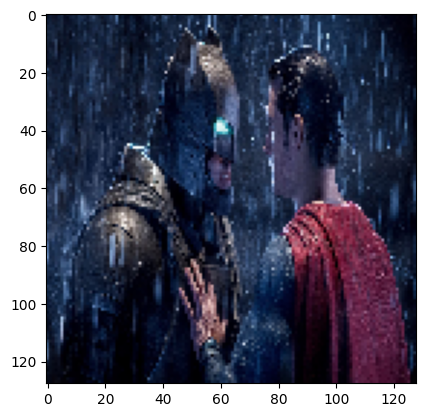

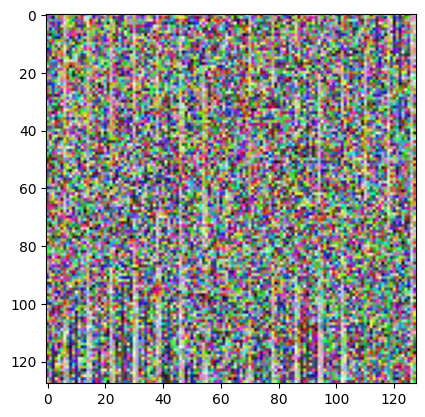

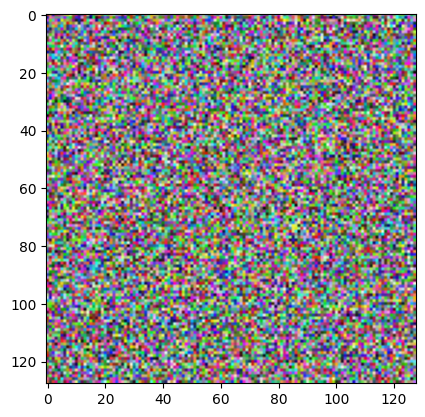

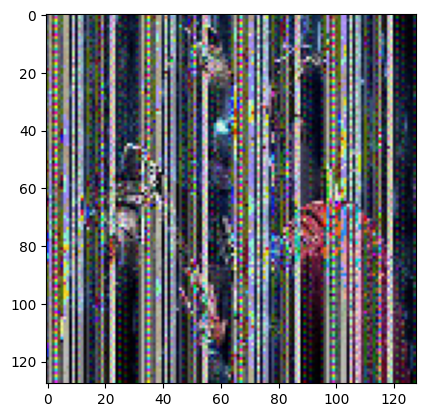

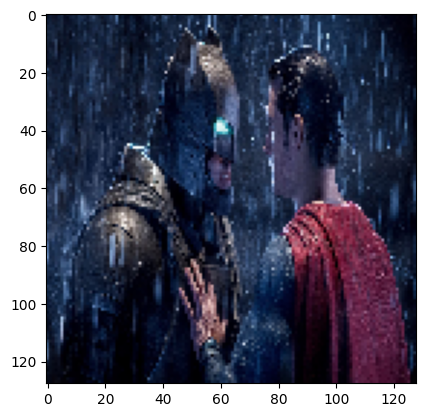

In [31]:
plt.imshow(img)
plt.show()
plt.imshow(ECB_encrypted_img)
plt.show()
plt.imshow(CBC_encrypted_img)
plt.show()
plt.imshow(OFB_encrypted_img)
plt.show()

# ======================================

plt.imshow(CBC_decrypted_img)